<a href="https://www.kaggle.com/code/miguelangelastaiza/climatewatch?scriptVersionId=190667438" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ClimateWacth

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, Input
from sklearn.model_selection import train_test_split
import cv2 
import os
import time
print("Tensorflow version " + tf.__version__)


E0000 00:00:1722474946.199267      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D0801 01:15:46.207300914      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0801 01:15:46.207314284      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0801 01:15:46.207317563      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0801 01:15:46.207319834      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0801 01:15:46.207322174      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

Tensorflow version 2.16.1


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('TPU initialized')
except Exception as e:
    print('Failed to initialize TPU:', e)
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1722474968.823134      13 service.cc:145] XLA service 0x56bac54c5d40 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722474968.823182      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1722474968.823187      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1722474968.823191      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1722474968.823194      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1722474968.823196      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1722474968.823199      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1722474968.823202      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1722474968.823205      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

# Carga y procesamiento de datos

In [3]:
def load_and_preprocess_images(folder_path):
    image_data = []    #imagenes
    labels = []        #etiquetas
    i = 0
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img = plt.imread(os.path.join(folder_path, filename))   #Leer imagen
            img = cv2.resize(img, (800, 800))  # Redimensiona a un tamaño fijo
            #img_flatten = img.flatten()  # Aplana la imagen a datos bidimensionales
            #i += 1
            #if i == 601:    #Para no leer todas las img
                #break
            
            image_data.append(img)
            if folder_path == "/kaggle/input/climate-pop/Soleado":
                labels.append(0)
            elif folder_path == "/kaggle/input/climate-pop/Rain":
                labels.append(1)
            else:
                labels.append(2)
            # 0 para imágenes de sol, 1 para imágenes de lluvia y 2 para imagenes de nublado
    
    return image_data, labels

In [4]:
# Carga de imagenes
sol_data, sol_labels = load_and_preprocess_images("/kaggle/input/climate-pop/Soleado")
lluvia_data, lluvia_labels = load_and_preprocess_images("/kaggle/input/climate-pop/Rain")
nublado_data, nublado_labels = load_and_preprocess_images("/kaggle/input/climate-pop/Nublado")

# Combinar datos
data = np.array(sol_data + lluvia_data + nublado_data)
labels = np.array(sol_labels + lluvia_labels + nublado_labels)

In [5]:
# train_test_split recibe x,y y crea un paquete de 75% para entreno y 25% para prueba
X_train, X_test, y_train, y_test = train_test_split(data,labels) # x son imagenes, y son etiquetas

print(X_train.shape) #imagenes de entreno
print(X_test.shape)  #imagenes de prueba

(2250, 800, 800, 3)
(750, 800, 800, 3)


0


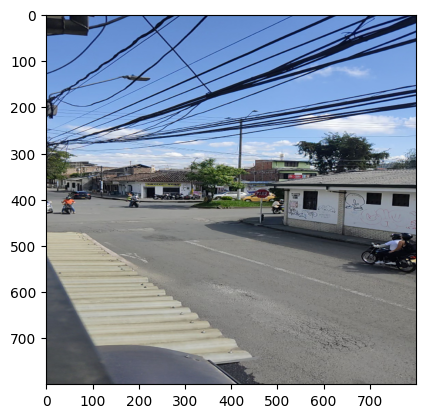

In [6]:
plt.imshow(X_train[10]);
print(y_train[10])

In [7]:
# Convertimos a flotante y normalizamos los datos solo de 0 a 1
train_images = X_train.astype('float32') / 255     # dividimos entre 255 porque es el valor maximo de un pixel
test_images = X_test.astype('float32') / 255

# para etiquetas 
train_labels = tf.keras.utils.to_categorical(y_train, 3)      # convertimos en un array de categoria, el 3 es porque existen 3 posibles clasificaciones
test_labels = tf.keras.utils.to_categorical(y_test, 3)

[1. 0. 0.]


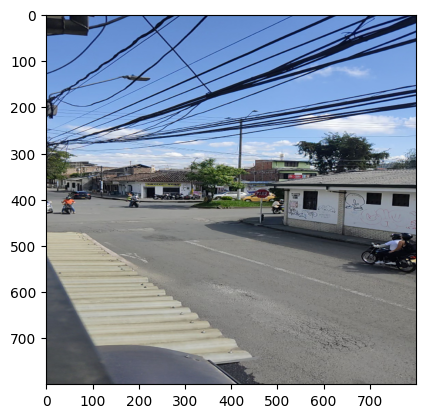

In [8]:
plt.imshow(train_images[10]);
print(train_labels[10])

In [9]:
# division del dataset en 3: train, val y test

(x_train, x_valid) = train_images[750:], train_images[:750]
(y_train, y_valid) = train_labels[750:], train_labels[:750]

print('Imagenes de entreno:', x_train.shape[0])
print('Imagenes de validacion:', x_valid.shape[0])
print('Imagenes de test:', test_images.shape[0])

Imagenes de entreno: 1500
Imagenes de validacion: 750
Imagenes de test: 750


# Creación y entreno del modelo

In [10]:
with strategy.scope(): 
    model = keras.Sequential()
    
    # Definir la capa de entrada
    model.add(Input(shape=(800, 800, 3)))   # input de 800 x 800 con 3 canales

    # primera capa convolucional 
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.0001)))      
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Segunda capa convolucional
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    # Tercera capa convolucional
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Cuarta capa convolucional
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))

    # Capa de aplanamiento
    model.add(Flatten())

    # Capa densa de salida
    model.add(Dense(3, activation='softmax'))      # solo 3 neuronas porque tenemos 3 posibles clasificaciones con softmax porque es para clasificar

    model.summary()
    
    # Compilacion
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 800, 800, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 800, 800, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 800, 800, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 800, 800, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 800, 800, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 800, 800, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 400, 400, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400, 400, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 400, 400, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 400, 400, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 400, 400, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 400, 400, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 400, 400, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 400, 400, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 400, 400, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 200, 200, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200, 200, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560000)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │     7,680,003 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,746,339 (29.55 MB)

 Trainable params: 7,745,955 (29.55 MB)

 Non-trainable params: 384 (1.50 KB)

I0000 00:00:1722475121.717472      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [11]:
# Entrenamiento
with strategy.scope(): 
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
    hist = model.fit(x_train, y_train, batch_size=16, epochs=12,          # batch_size indica que no voy a utilizar todas las imagenes por epoca si no pequeños lotes de 8
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stopping])

Epoch 1/12


2024-08-01 01:19:30.111270: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1722475170.917791     804 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(eb3a442f4555e86:0:0), session_name()


 1/94 ━━━━━━━━━━━━━━━━━━━━ 34:44 22s/step - accuracy: 0.5000 - loss: 1.5604

I0000 00:00:1722475184.327514     804 tpu_compile_op_common.cc:245] Compilation of eb3a442f4555e86:0:0 with session name  took 13.409631635s and succeeded
I0000 00:00:1722475184.338685     804 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(eb3a442f4555e86:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_7954112480832930370", property.function_library_fingerprint = 3499584120782668664, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,800,800,3,;2,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722475184.338746     804 tpu_compilation_cache_interface.cc:541] After adding entry for key eb3

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7979 - loss: 129.1581

I0000 00:00:1722475213.493523     780 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(25f970db990687d:0:0), session_name()
I0000 00:00:1722475228.062333     780 tpu_compile_op_common.cc:245] Compilation of 25f970db990687d:0:0 with session name  took 14.568743162s and succeeded
I0000 00:00:1722475228.064575     780 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(25f970db990687d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_7853573855663381237", property.function_library_fingerprint = 2751935199848341821, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,800,800,3,;2,3,;", property.guaranteed_constants_size = 0, embeddin

94/94 ━━━━━━━━━━━━━━━━━━━━ 69s 501ms/step - accuracy: 0.7990 - loss: 128.5383 - val_accuracy: 0.8085 - val_loss: 8.0579
Epoch 2/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 0.9894 - val_loss: 0.3022
Epoch 3/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 1.0000 - val_loss: 0.0151
Epoch 4/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 1.0000 - val_loss: 0.0151
Epoch 5/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 1.0000 - val_loss: 0.0151
Epoch 6/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 1.0000 - val_loss: 0.0151
Epoch 7/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 1.0000 - val_loss: 0.0151
Epoch 8/12
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 1.0

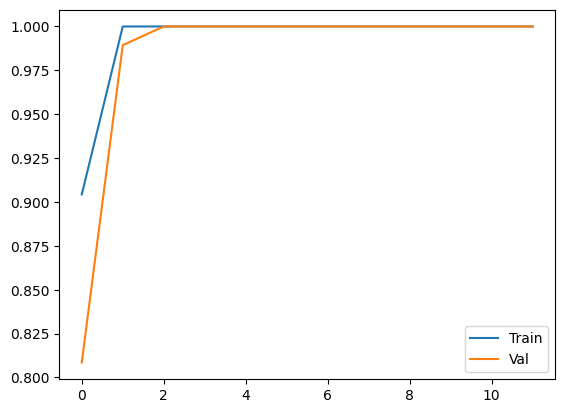

In [12]:
# Visualizacion de la presicion
plt.plot(hist.history['accuracy'],label='Train')
plt.plot(hist.history['val_accuracy'],label='Val')
plt.legend()
plt.show()

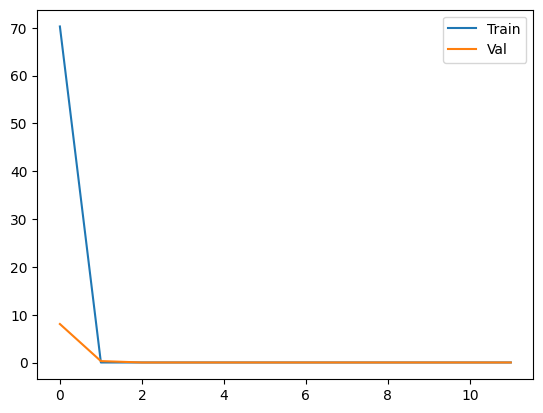

In [13]:
# Visualizacion de la perdida
plt.plot(hist.history['loss'],label='Train')
plt.plot(hist.history['val_loss'],label='Val')
plt.legend()
plt.show()

In [14]:
with strategy.scope(): 
    model.evaluate(test_images,test_labels)

I0000 00:00:1722475473.134369     827 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f5e3c85c0363612f:0:0), session_name()


 1/24 ━━━━━━━━━━━━━━━━━━━━ 6:44 18s/step - accuracy: 1.0000 - loss: 0.0151

I0000 00:00:1722475489.803219     827 tpu_compile_op_common.cc:245] Compilation of f5e3c85c0363612f:0:0 with session name  took 16.668793371s and succeeded
I0000 00:00:1722475489.805939     827 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f5e3c85c0363612f:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_7853573855663381237", property.function_library_fingerprint = 2751935199848341821, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,800,800,3,;4,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722475489.805974     827 tpu_compilation_cache_interface.cc:541] After adding entry for key f

24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 184ms/step - accuracy: 1.0000 - loss: 0.0151


In [ ]:
tf.saved_model.save(model, '/kaggle/working/climatewatch_model')
print("Modelo guardado exitosamente en /kaggle/working/")

In [ ]:
import shutil

# Define el nombre de la carpeta y el archivo ZIP
carpeta_a_comprimir = '/kaggle/working/climatewatch_model2'
archivo_zip = '/kaggle/working/climatewatch_model2.zip'

# Comprime la carpeta
shutil.make_archive('/kaggle/working/climatewatch_model2', 'zip', carpeta_a_comprimir)
print("Carpeta comprimida exitosamente.")

# Deteccion del estado del tiempo en tiempo real


In [ ]:
# Cargar el modelo guardado
path = "/kaggle/working/climatewatch_model"
# Cargar el modelo usando TFSMLayer
model = tf.keras.Sequential([
    TFSMLayer(path, call_endpoint='serving_default')
])
print("Modelo cargado exitosamente.")
model.summary()

In [ ]:
# Inicializar la cámara
cap = cv2.VideoCapture('http://192.168.0.3:8080/video')  

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocesar la imagen capturada
    img1 = cv2.resize(frame, (800, 800))
    img = img1 / 255  # Normalizar la imagen
    img = np.expand_dims(img, axis=0)  # Agregar una dimensión para el batch
    
    # Hacer la predicción
    pred_dict = model.predict(img)
    pred = pred_dict[list(pred_dict.keys())[0]]
    pred_class = np.argmax(pred, axis=-1)[0]  # Obtener la clase predicha

    # Mostrar la predicción en la imagen
    label = ["Soleado", "Lluvia", "Nublado"][pred_class]
    cv2.putText(img1, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Mostrar la imagen
    cv2.imshow('ClimateWatch', img1)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()